### Step 5: Machine Learning Model Evaluation

This notebook loads feature and label data from a csv file, which was generated in the previous "data wrangling" step. The last column in the csv file are labels. The rest columns are features.

We use the data to train and evaluate various machine learning models. The purpose of this notebook is to find out the accuracy of these machine learning models with the training features. The training features and model parameters can be tweaked in order to find the optimal model which is most suitable for our research goal.

Here we use scikit-learn as example. You can choose other machine learning platforms, such as TensorFlow, Keras and PyTorch. If you don't like coding, maybe try Ludwig or Northstar.

Cross validate the machine learning model 10 times.
Evaluate the 10 scores to decide if the model is good enough to be used to predict new data.

Scores: [0.84, 0.74, 0.77, 0.74, 0.74, 0.61, 0.71, 0.81, 0.77, 0.84]
Score Mean: 0.76, Score Standard Deviation: 0.0633
Accuracy: 0.76 (+/- 0.1266)      #95% confidence interval of the score estimate


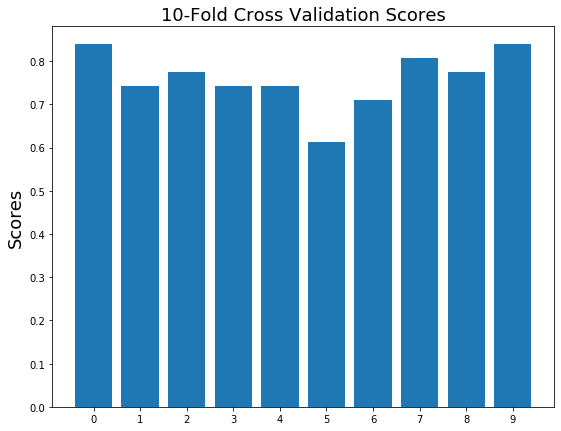

In [34]:
#Import the tools for machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np

#read in data for machine learning training and testing
all_data_in_file = np.genfromtxt('machine_learning_train_test_data.csv',delimiter=',')
labels = all_data_in_file[:,-1]
data = all_data_in_file[:,:4]

#choose classifier
classifier = 'RFC' #random forest
#classifier = 'SVC' #support vector Classification 

#preprocess features and split data for training and testing
data = preprocessing.scale(data)
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=1)

if classifier == 'RFC':
    #create and train the random forest
    #multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
    #n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
    clf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)
elif classifier == 'SVC':
    clf = SVC(probability=True,class_weight=None, gamma='auto')
    
#cross validate the estimator    
#https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation
scores = cross_val_score(clf, data, labels, cv=10)
print('Cross validate the machine learning model 10 times.')
print('Evaluate the 10 scores to decide if the model is good enough to be used to predict new data.\n')
print(f"Scores: {[round(x,2) for x in scores]}")
print(f"Score Mean: {round(np.mean(scores), 2)}, Score Standard Deviation: {round(np.std(scores),4)}")
print(f"Accuracy: {round(np.mean(scores), 2)} (+/- {round(np.std(scores)*2,4)})\
      #95% confidence interval of the score estimate")

#plot the bar chart
fig, ax = plt.subplots(figsize=(9, 7))
plt.bar(np.arange(10), scores)
ax.set_ylabel('Scores', fontsize=18)
ax.set_title('10-Fold Cross Validation Scores',fontsize=18)
ax.set_xticks(np.arange(10))
plt.show()

Use the train dataset to train the model and predict on the test dataset.
The bar chart indicates the model's predication of deposit probabilities.
Score with train and test data: 0.71


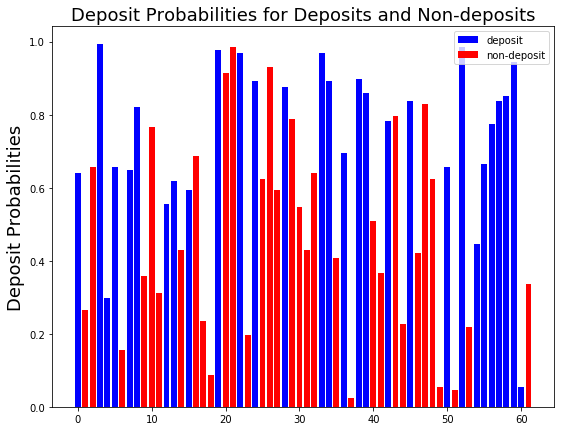

In [18]:
#train the machine learning model with train and test data
#and then predict
clf.fit(train_data, train_labels)
score=clf.score(test_data, test_labels)
print('Use the train dataset to train the model and predict on the test dataset.')
print('The bar chart indicates the model\'s predication of deposit probabilities.')
print(f'Score with train and test data: {round(score,2)}')

proba=clf.predict_proba(test_data)
predict_labels=clf.predict(test_data)

#plot the probabilities
fig, ax = plt.subplots(figsize=(9, 7))
tmp = np.c_[np.arange(62), test_labels, proba]
deposit = tmp[tmp[:,1]==1]
non_deposit = tmp[tmp[:,1]==0]
ax.bar(deposit[:,0], deposit[:,3], color='blue', label='deposit')
ax.bar(non_deposit[:,0], non_deposit[:,3], color='red', label='non-deposit')
ax.set_ylabel('Deposit Probabilities', fontsize=18)
ax.set_title('Deposit Probabilities for Deposits and Non-deposits',fontsize=18)
plt.legend(loc='upper right')
plt.show()

The bar chart shows the model's predication of deposit probabilities and 
the colors show the correct prediction, false positive and false negative predictions.


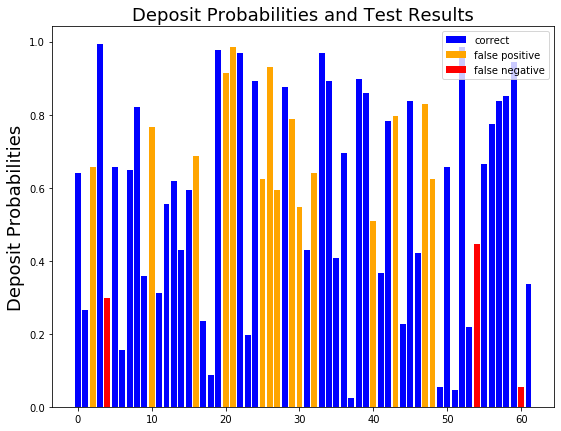

In [19]:
print('The bar chart shows the model\'s predication of deposit probabilities and ')
print('the colors show the correct prediction, false positive and false negative predictions.')
#plot the probabilities with true, false positive and false negative
fig, ax = plt.subplots(figsize=(9, 7))
tmp = np.c_[np.arange(62), predict_labels, test_labels, proba]
correct_predict = tmp[tmp[:,1]==tmp[:,2]]
tmp=tmp[tmp[:,1]!=tmp[:,2]]
false_positive = tmp[tmp[:,1]==1]
false_negative = tmp[tmp[:,1]==0]
ax.bar(correct_predict[:,0], correct_predict[:,4], color='blue', label='correct')
ax.bar(false_positive[:,0], false_positive[:,4], color='orange', label='false positive')
ax.bar(false_negative[:,0], false_negative[:,4], color='red', label='false negative')
ax.set_ylabel('Deposit Probabilities', fontsize=18)
ax.set_title('Deposit Probabilities and Test Results',fontsize=18)
plt.legend(loc='upper right')
plt.show()

For Random Forest model, the bar chart shows the weight of each feature in decision making.


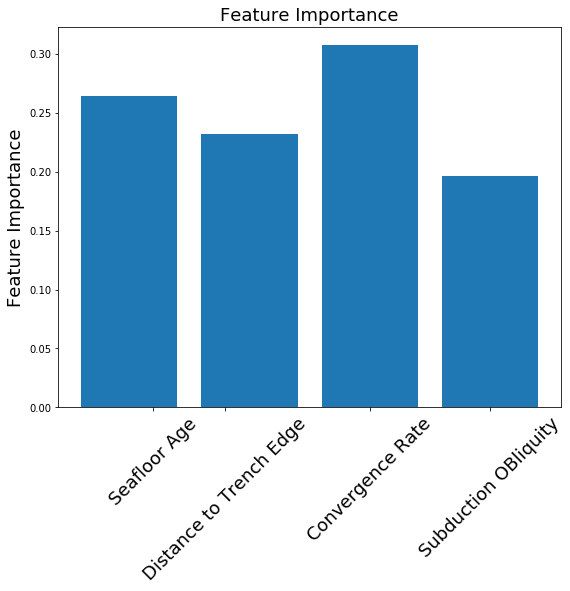

In [20]:
if classifier == 'RFC':
    print('For Random Forest model, the bar chart shows the weight of each feature in decision making.')
    #plot the feature importance if using Random Forest Classifier. 
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.bar(np.arange(len(clf.feature_importances_)), clf.feature_importances_)
    ax.set_ylabel('Feature Importance', fontsize=18)
    ax.set_title('Feature Importance',fontsize=18)
    ax.set_xticks([0.2,0.8,2.0,3.0])
    feature_names = ["Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction OBliquity"]
    ax.set_xticklabels(feature_names, rotation=45, fontsize=18)
    plt.show()
    #print(clf.feature_importances_)

Run the machine learning model on the whole trench sampling points dataset to see which areas have higher proboblilites of ore deposit. 

(91009, 2)
(310, 7)


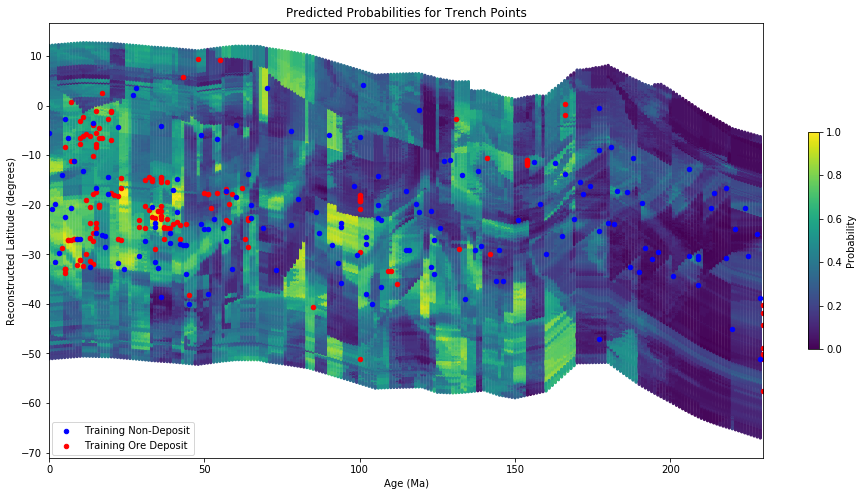

In [43]:
#train the ML model
clf.fit(data, labels)

#read in test data and predict
trench_data = np.genfromtxt('machine_learning_trench_data.csv',delimiter=',')
test_data = preprocessing.scale(trench_data[:,:4])
trench_proba=clf.predict_proba(test_data)

#make a plot
fig, ax = plt.subplots(figsize=(16, 8))
plt.xlim([0,230])
cb = plt.scatter(trench_data[:,5],trench_data[:,4], c=trench_proba[:,1],s=10,marker='o',edgecolor='none')

p1 = plt.scatter(all_data_in_file[:155,5],all_data_in_file[:155,4], 
                 color='red',s=20,marker='o')
p2 = plt.scatter(all_data_in_file[155:155*2,5],all_data_in_file[155:155*2,4], 
                 color='blue',s=20,marker='o')

fig.colorbar(cb, shrink=0.5, label='Probability')
plt.title('Predicted Probabilities for Trench Points')
plt.ylabel('Reconstructed Latitude (degrees)')
plt.xlabel('Age (Ma)')
ax.legend([p2,p1],["Training Non-Deposit","Training Ore Deposit"],
            loc=3, borderaxespad=0.3,numpoints=1)
plt.show()

### THE END